# Probabilistic Regression - ODSC East 2025

- ## When predicting a numerical target, we are accustomed to "settling" for a mere point estimate.
- ## However, it would be preferable to have a (reliable) probability distribution over the range of possible values.
- ## That is the goal of probabilistic regression (Conditional Density Estimation).

## Imports

In [1]:
# Uncomment and run these lines if running on Google Colab (or if not installed yet)

# !pip install structureboost


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import structureboost as stb


## Load / Process Dataset
We will start by analyzing the *Concrete* dataset from the UC-Irvine repository.  The goal is to predict the strength of concrete mixtures based on some attributes about the "recipe" which created it.

In [3]:
# Use if repo is cloned and you are running locally
df_concrete = pd.read_csv("../ODSC_East_2023/concr_mod.csv")

# Use if running on Google Colab
# df_concrete = pd.read_csv("https://raw.githubusercontent.com/numeristical/resources/refs/heads/master/ODSC_East_2023/concr_mod.csv")

In [4]:
print(df_concrete.shape)
df_concrete.head()

(1030, 9)


,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_agg,fine_agg,age_days,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


- ## In this dataset, we are attempting to predict the strength of concrete given certain aspects of the "recipe"

np.float64(35.8178358261136)

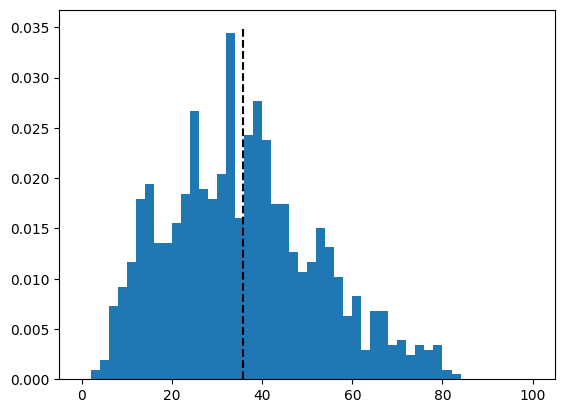

In [5]:
# Here is the marginal probability density 
plt.hist(df_concrete.strength, bins=np.linspace(0,100,51), density=True);
plt.vlines(np.mean(df_concrete.strength), ymin=0, ymax=.035, color='k', linestyle='--')
np.mean(df_concrete.strength)

- ## Suppose we knew nothing about a particular batch of concrete, and were asked to predict its strength:
    - ## Point prediction: predict the mean, 35.8
    - ## Probabilistic regression: predict the distribution above, which indicates a specific probability of being in each interval

- ## To measure the quality of a prediction, given the actual value (say, 52)
    - ## Point prediction: Look at the distance between 35.8 and 52 (mean absolute error, mean squared error, etc.)
    - ## Probabilistic regression: Several possibilites, most common would be to look at the probability (density) at the true answer.

- ## Why predict distributions?
    - ## The mean gives limited information!
    - ## If the predicted mean is 50, this could signify any of the following situations:

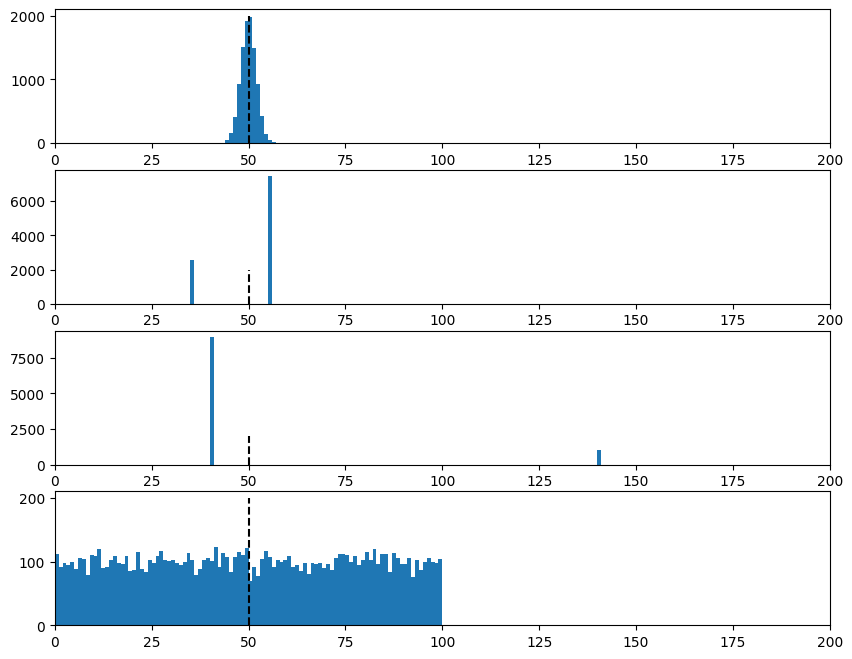

In [6]:
vec1 = np.random.normal(50,2,size=10000)
vec2 = np.random.choice(a=[35,55], p=[.25, .75], size=10000)
vec3 = np.random.choice(a=[40,140], p=[.90, .1], size=10000)
vec4 = np.random.uniform(0,100, size=10000)
bv=np.arange(201)
plt.figure(figsize=(10,8))
plt.subplot(4,1,1)
plt.hist(vec1, bins=bv)
plt.xlim([0,200])
plt.vlines(50,ymin=0, ymax=2000, color='k', linestyle='--')
plt.subplot(4,1,2)
plt.hist(vec2, bins=bv)
plt.xlim([0,200])
plt.vlines(50,ymin=0, ymax=2000, color='k', linestyle='--')
plt.subplot(4,1,3)
plt.hist(vec3, bins=bv)
plt.xlim([0,200])
plt.vlines(50,ymin=0, ymax=2000, color='k', linestyle='--')
plt.subplot(4,1,4)
plt.hist(vec4, bins=bv)
plt.xlim([0,200])
plt.vlines(50,ymin=0, ymax=200, color='k', linestyle='--')

- ## But we would likely make different decisions in these situations!

# Quick refresher - Gradient boosting in a multiclass setting (suppose k=5)
- ### We start (each iteration) with a predicted distribution for each point in the training set:
  - ### e.g. pt 1: (.1, .2, .2, .1, .4)
  - ### e.g. pt 37: (.05, .4, .05, .3, .2)
- ### Taking these predicted distributions and the actual values, we calculate gradients
  - ### These represent whether or not we want to increase or decrease the probability of each class, based on the loss function and the actual
  - ### e.g. pt 1:  is actually class 2, so gradient is (-, +, -, -, --)
  - ### e.g. pt 37:  is actually class 5, so gradient is (-, --, -, --, +)
- ### We then build a decision tree to predict the gradient based on our features
- ### Leaves of this tree (hopefully) capture data points with similar gradients
- ### Then we add this tree to the forest, update our predictions and iterate again

# Coarsage
- ## Frame predicting distributions as a high cardinality multiclass classification problem
- ## e.g. If target is between 0 and 100, break it into 100 intervals of length 1, or 1000 intervals of length 0.1
- ## Since cardinality is so high, at each iteration, we randomly coarsen the distribution into a "manageable" number of intervals
- ## We then follow the multiclass approach above to create the next tree
- ## When we apply the new tree to our previous predictions, we do it at the fine discretization level
- ## (Additionally, we can use loss functions which are aware or the ordinal structure of the numbers)

In [7]:
np.random.seed(999)
foldnum = np.random.randint(0,10,df_concrete.shape[0])
pd.Series(foldnum).value_counts()

1    113
3    112
6    110
5    109
0    106
2    106
9    102
7     92
8     90
4     90
Name: count, dtype: int64

In [8]:
# 70% train, 10% valid, 20% test
dfc_train = df_concrete[foldnum<=6]
dfc_valid = df_concrete[(foldnum>6) & (foldnum<=7)]
dfc_test = df_concrete[foldnum>7]

dfc_train_val = pd.concat((dfc_train, dfc_valid))

In [9]:
features = df_concrete.columns[:-1].tolist()
target = 'strength'
X_train = dfc_train.loc[:,features]
y_train = dfc_train[target].to_numpy()

X_valid = dfc_valid.loc[:,features]
y_valid = dfc_valid[target].to_numpy()

X_test = dfc_test.loc[:,features]
y_test = dfc_test[target].to_numpy()

X_train_val = dfc_train_val.loc[:,features]
y_train_val = dfc_train_val[target].to_numpy()


## Quick Demo

In [10]:
# Choose bins of width 5 as the fine discretization
bin_pts_conc = np.linspace(0,90,19)
bin_pts_conc

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
       65., 70., 75., 80., 85., 90.])

In [11]:
cr_demo = stb.Coarsage(num_trees=100,learning_rate=.07, max_depth=5, binpt_method='fixed_rss',binpt_vec=bin_pts_conc,
                   num_coarse_bins=5, loss_fn='log_loss')
cr_demo.fit(X_train, y_train)

i=0
i=10
i=20
i=30
i=40
i=50
i=60
i=70
i=80
i=90


In [12]:
tree_num = 60
pt_a = 10
pt_b = 35

In [13]:
# Lets compare the training predictions before and after the addition of a particular tree
preds_demo_train_before = cr_demo.predict_distributions(X_train, num_trees_to_use=tree_num)
preds_demo_train_after = cr_demo.predict_distributions(X_train, num_trees_to_use=tree_num+1)

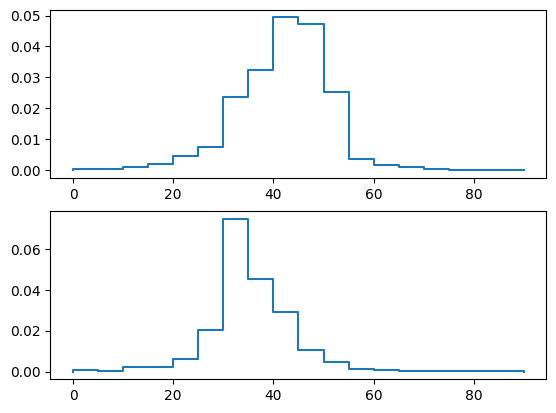

In [14]:
# These are the predictions before
plt.subplot(2,1,1)
preds_demo_train_before[pt_a].plot_density()
plt.subplot(2,1,2)
preds_demo_train_before[pt_b].plot_density()


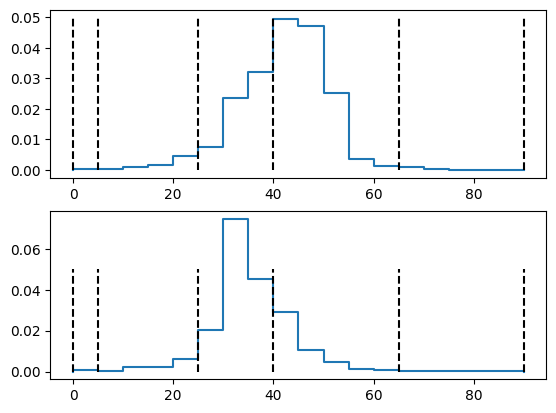

In [15]:
# Next we randomly choose a coarsening to 5 bins
plt.subplot(2,1,1)
preds_demo_train_before[pt_a].plot_density()
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.05, color='k', linestyle='--')
plt.subplot(2,1,2)
preds_demo_train_before[pt_b].plot_density()
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.05, color='k', linestyle='--')


In [16]:
pt_a_coarsened = stb.PdfDiscrete(cr_demo.binpt_vec_list[tree_num], preds_demo_train_before[pt_a].bins_to_probs(cr_demo.binpt_vec_list[tree_num]))
pt_b_coarsened = stb.PdfDiscrete(cr_demo.binpt_vec_list[tree_num], preds_demo_train_before[pt_b].bins_to_probs(cr_demo.binpt_vec_list[tree_num]))


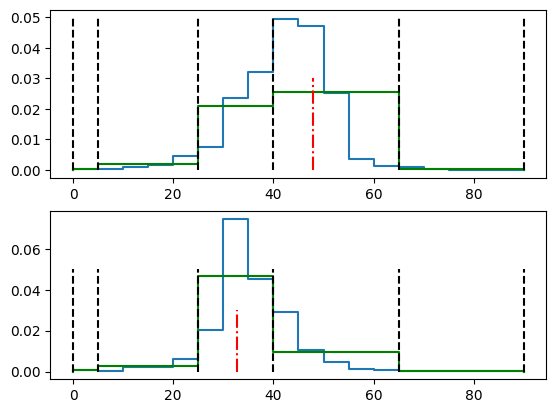

In [17]:
# Next we randomly choose a coarsening to 5 bins
plt.subplot(2,1,1)
preds_demo_train_before[pt_a].plot_density()
pt_a_coarsened.plot_density(color='green')
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.05, color='k', linestyle='--')
plt.vlines(y_train[pt_a], ymin=0, ymax=0.03, color='red', linestyle='-.')
plt.subplot(2,1,2)
preds_demo_train_before[pt_b].plot_density()
pt_b_coarsened.plot_density(color='green')
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.05, color='k', linestyle='--')
plt.vlines(y_train[pt_b], ymin=0, ymax=0.03, color='red', linestyle='-.')


## Now, we compute the gradients as if it were a 5-class multiclass classification

## Then we apply those gradients back to the previous fine-grained distributions

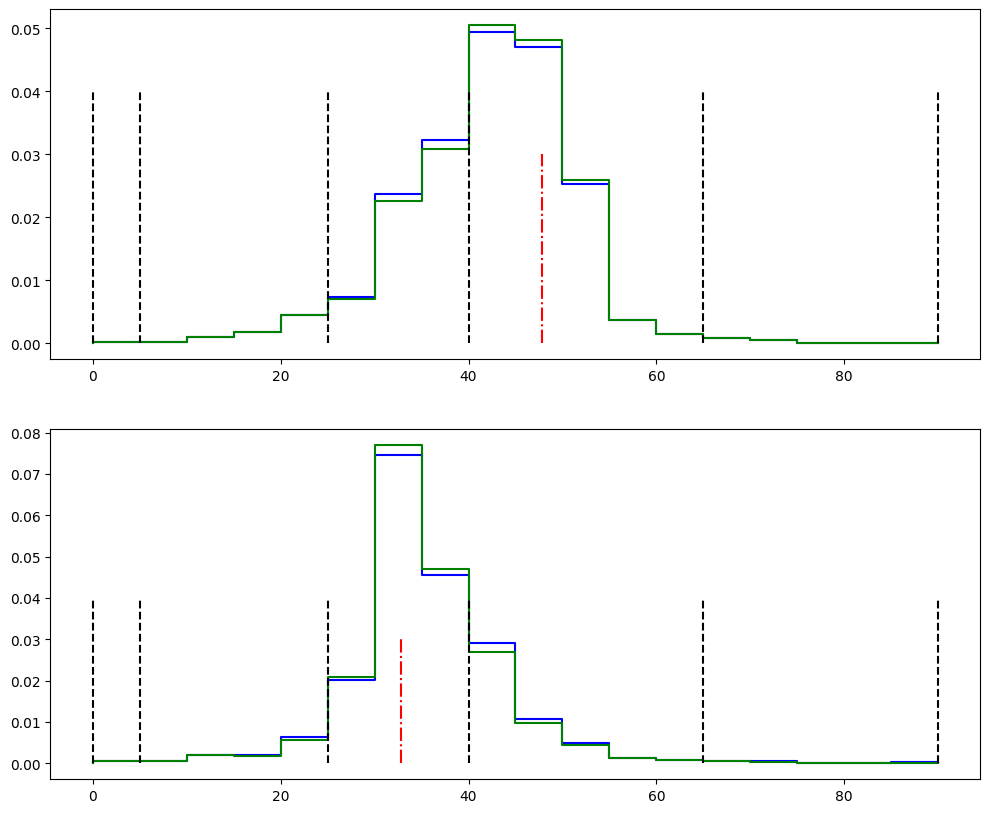

In [18]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
preds_demo_train_before[pt_a].plot_density(color='blue')
preds_demo_train_after[pt_a].plot_density(color='green')
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.04, color='k', linestyle='--')
plt.vlines(y_train[pt_a], ymin=0, ymax=0.03, color='red', linestyle='-.')
plt.subplot(2,1,2)
preds_demo_train_before[pt_b].plot_density(color='blue')
preds_demo_train_after[pt_b].plot_density(color='green')
plt.vlines(cr_demo.binpt_vec_list[tree_num], ymin=0, ymax=0.04, color='k', linestyle='--')
plt.vlines(y_train[pt_b], ymin=0, ymax=0.03, color='red', linestyle='-.')

# Complication 1: Choice of loss function
- ## Governed by the argument `loss_fn`
- ## Currently 3 options: `log_loss`, `log_loss_str`, `crps_disc`
- ## When you use (standard) log loss as your loss function, the gradients only care about the "right" bin
  - ### Will not recognize that 22 is close to 21, but far from 67
- ## The "Structured entropy loss function" `log_loss_str` (computes log loss over a several different coarsened versions and averages them)
  - ## Tends to smooth and regularize the distributions a bit more
- ## Continuous Ranked Probability Score (CRPS) - looks across distribution and credits having more mass closer to the answer
  - ## Option `crps_disc` uses a discrete version of the CRPS as a loss function for computing the gradient
- ## Both structured log loss and CRPS are "proper" scoring rules

# Complication 2: Discretization choices
- ## Need to decide the "finest possible discretization" (or allow unlimited discretization)
- ## Need to determine the random coarsening at each iteration
- ## In the example above, we designated the "finest" possible discretization and then the algorithm chose random coarsenings
  - ## This corresponds to the option: `binpt_method='fixed_rss'`
    - ### need to specify the finest possible discretization: `binpt_vec`
    - ### need to specify how many bins to coarsen to at each iteration: `num_coarse_bins`
- ## There are two other options available:
  - ## `binpt_method='fixed'`
  - ## Can choose to not coarsen if your "finest" possible discretization is already low in cardinality.
    - ### e.g. your actual values are integers between 1 and 10, can just look at all 10 bins every time
    - ### Definitely not recommended if you have more than, say, 30 bins
  - ## Alternatively you can decline to choose a discretization and let Coarsage "figure it out"
    - ### Corresponds to option `binpt_method='auto'`

In [19]:
# Choose a "finest" discretization of 90 bins
bin_pts_conc = np.linspace(0,90,91)
bin_pts_conc

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.,
       65., 66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77.,
       78., 79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.])

In [20]:
pt1, pt2 = 4, 43

## Let's explore the results under different settings

### `binpt_method='fixed'`, `loss_fn='log_loss'`

- ### This is most similar to what you would get if you just discretized and treated as a multiclass problem in another boosting package

In [21]:
cr1 = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, binpt_method='fixed',
                   binpt_vec=bin_pts_conc, loss_fn='log_loss')
cr1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 4.495144877215671
i=10, eval_set_loss = 4.357511643828456
i=20, eval_set_loss = 4.264056889920739
i=30, eval_set_loss = 4.193271877572687
i=40, eval_set_loss = 4.151132833328102
i=50, eval_set_loss = 4.1129065500559046
i=60, eval_set_loss = 4.08500446875058
i=70, eval_set_loss = 4.054172268752847
i=80, eval_set_loss = 4.0446520693988655
i=90, eval_set_loss = 4.045135697206938
i=100, eval_set_loss = 4.026781962495821
i=110, eval_set_loss = 4.015066118402805
i=120, eval_set_loss = 4.006021045693074
i=130, eval_set_loss = 4.008425694488879
i=140, eval_set_loss = 4.011358148529937
i=150, eval_set_loss = 4.013906699942512
i=160, eval_set_loss = 4.018053932845539
i=170, eval_set_loss = 4.024895025096545
Stopping early: low pt was 5 steps ago


In [22]:
cr1_preds = cr1.predict_distributions(X_test)
cr1_preds.log_loss(y_test), cr1_preds.crps_mean(y_test)

(np.float64(3.7843368985619334), np.float64(5.219188320314845))

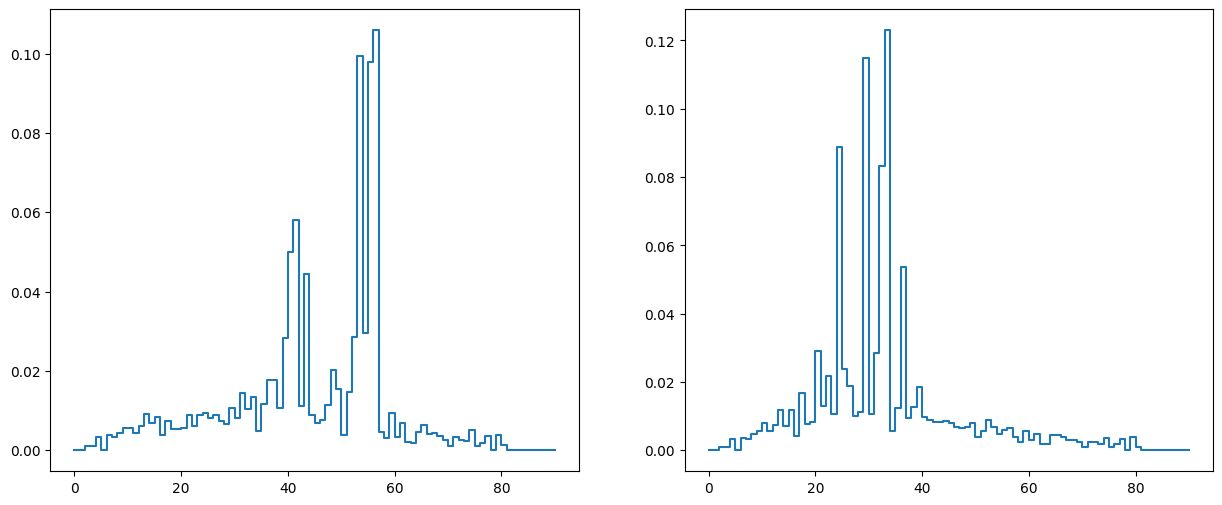

In [23]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr1_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr1_preds[pt2].plot_density()

### `binpt_method='fixed_rss'`, `loss_fn='log_loss'`

- ### This shows the improvement we get by coarsening to 20 bins at each iteration, rather than operation under 90 classes
- ### We are still using the standard log_loss - so the loss function doesn't know the structure of the classes

In [24]:
cr1a = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, binpt_method='fixed_rss',
                   binpt_vec=bin_pts_conc, num_coarse_bins=20, loss_fn='log_loss')
cr1a.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 4.115851720792188
i=10, eval_set_loss = 3.8169792842306314
i=20, eval_set_loss = 3.6294661570601883
i=30, eval_set_loss = 3.511525645463495
i=40, eval_set_loss = 3.418434883628479
i=50, eval_set_loss = 3.3514795352027305
i=60, eval_set_loss = 3.2891778779932683
i=70, eval_set_loss = 3.2374272073534685
i=80, eval_set_loss = 3.1935150764679547
i=90, eval_set_loss = 3.171092245519452
i=100, eval_set_loss = 3.1651095678749512
i=110, eval_set_loss = 3.1576321229600826
i=120, eval_set_loss = 3.1462543628785453
i=130, eval_set_loss = 3.1388738491384314
i=140, eval_set_loss = 3.1408332152618645
i=150, eval_set_loss = 3.131942272317128
i=160, eval_set_loss = 3.128321595913229
i=170, eval_set_loss = 3.1261712284599605
i=180, eval_set_loss = 3.121205225775979
i=190, eval_set_loss = 3.120295735789591
i=200, eval_set_loss = 3.123393671593323
i=210, eval_set_loss = 3.1195147083139316
i=220, eval_set_loss = 3.118753364874013
i=230, eval_set_loss = 3.1188353700491325
i=240, eval_s

In [25]:
cr1a_preds = cr1a.predict_distributions(X_test)
cr1a_preds.log_loss(y_test), cr1a_preds.crps_mean(y_test)

(np.float64(3.1885626838093963), np.float64(3.1165074260815544))

In [26]:
# Previous values
cr1_preds.log_loss(y_test), cr1_preds.crps_mean(y_test)

(np.float64(3.7843368985619334), np.float64(5.219188320314845))

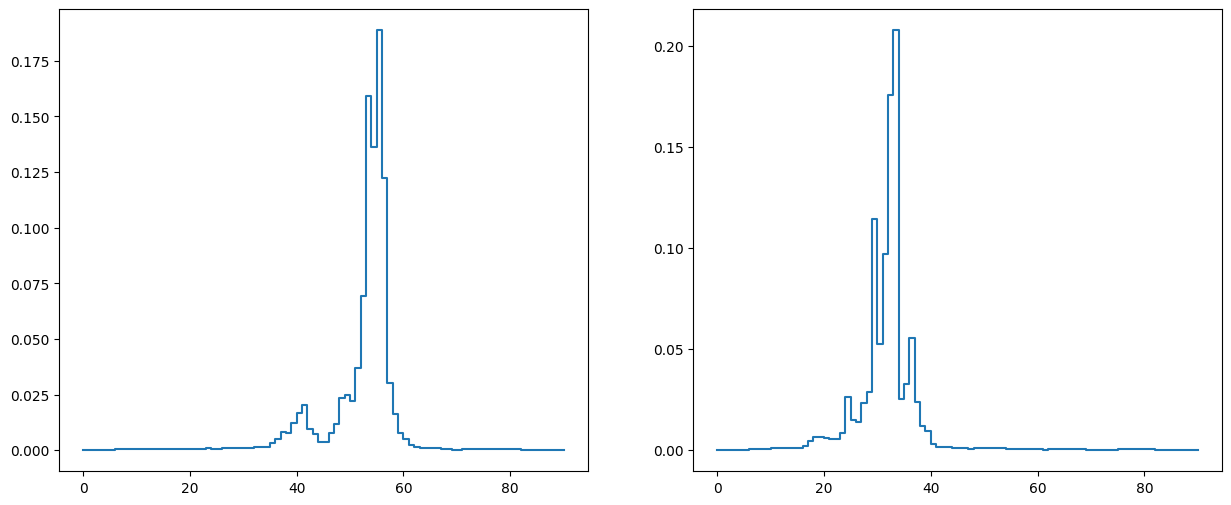

In [27]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr1a_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr1a_preds[pt2].plot_density()

### `binpt_method='fixed_rss'`, `loss_fn='log_loss_str'`

- ### This shows the additional improvement we get by using the "structured" log_loss

In [28]:
cr1b = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, binpt_method='fixed_rss',
                   binpt_vec=bin_pts_conc, num_coarse_bins=20, loss_fn='log_loss_str')
cr1b.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 4.115851720792188
i=10, eval_set_loss = 3.860179748286708
i=20, eval_set_loss = 3.6390305514680126
i=30, eval_set_loss = 3.4969997946053204
i=40, eval_set_loss = 3.373314435743448
i=50, eval_set_loss = 3.3039405472451024
i=60, eval_set_loss = 3.240642571475699
i=70, eval_set_loss = 3.183082336842825
i=80, eval_set_loss = 3.1440964030238594
i=90, eval_set_loss = 3.104807832732064
i=100, eval_set_loss = 3.082577903162715
i=110, eval_set_loss = 3.0615324501532335
i=120, eval_set_loss = 3.0479774836125744
i=130, eval_set_loss = 3.0318117428212905
i=140, eval_set_loss = 3.0191160797055714
i=150, eval_set_loss = 3.011410986109213
i=160, eval_set_loss = 2.9930307631763466
i=170, eval_set_loss = 2.9898781433022923
i=180, eval_set_loss = 2.9789037791149253
i=190, eval_set_loss = 2.9754762247132365
i=200, eval_set_loss = 2.9746100725452167
i=210, eval_set_loss = 2.9719136852146386
i=220, eval_set_loss = 2.975438006371906
i=230, eval_set_loss = 2.9763772336912244
i=240, eval_

In [29]:
cr1b_preds = cr1b.predict_distributions(X_test)
cr1b_preds.log_loss(y_test), cr1b_preds.crps_mean(y_test)

(np.float64(3.168086849138659), np.float64(3.048862735201086))

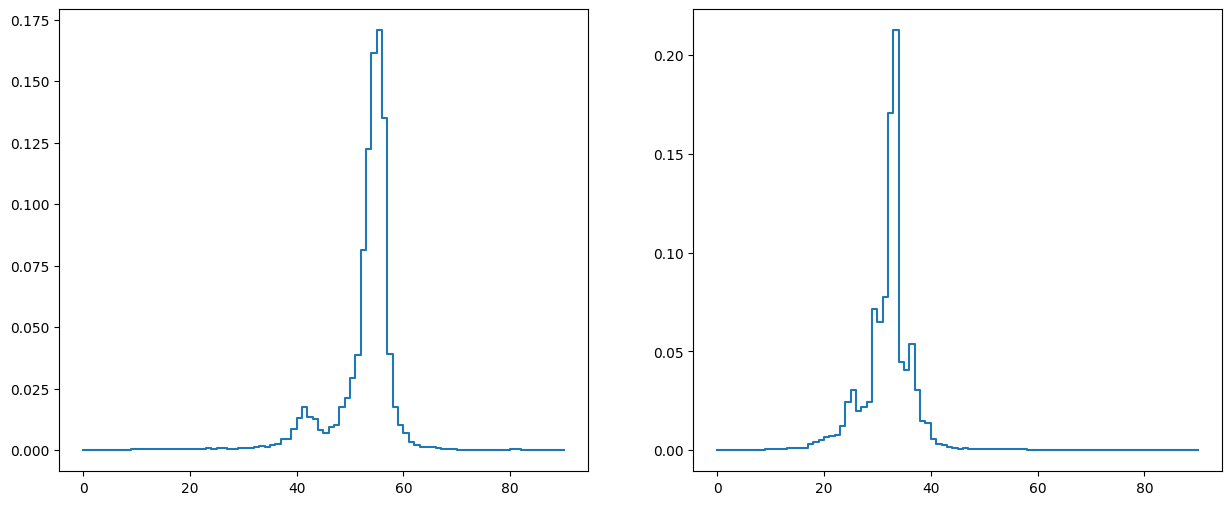

In [30]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr1b_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr1b_preds[pt2].plot_density()

### `binpt_method='fixed_rss'`, `loss_fn='log_loss'`

- ### This shows the improvement we get by coarsening to 20 bins at each iteration, rather than operation under 90 classes
- ### We are still using the standard log_loss - so the loss function doesn't know the structure of the classes

In [31]:
cr1c = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, binpt_method='fixed_rss',
                   binpt_vec=bin_pts_conc, num_coarse_bins=20, loss_fn='crps_disc')
cr1c.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 9.061624187695182
i=10, eval_set_loss = 7.661139323290601
i=20, eval_set_loss = 6.4575328779097285
i=30, eval_set_loss = 5.584754915052448
i=40, eval_set_loss = 4.9191358632908
i=50, eval_set_loss = 4.47230287970535
i=60, eval_set_loss = 4.159501245532615
i=70, eval_set_loss = 3.927634830444879
i=80, eval_set_loss = 3.7405625953497803
i=90, eval_set_loss = 3.6176396996658866
i=100, eval_set_loss = 3.540267212730852
i=110, eval_set_loss = 3.4786368951924014
i=120, eval_set_loss = 3.415349054444042
i=130, eval_set_loss = 3.3798892103882454
i=140, eval_set_loss = 3.320725835028084
i=150, eval_set_loss = 3.2893527159351588
i=160, eval_set_loss = 3.2546212155341028
i=170, eval_set_loss = 3.2228103043898084
i=180, eval_set_loss = 3.1847126147953353
i=190, eval_set_loss = 3.1677056522798006
i=200, eval_set_loss = 3.1426158518259024
i=210, eval_set_loss = 3.114600915592577
i=220, eval_set_loss = 3.0984940152000857
i=230, eval_set_loss = 3.0771701921258936
i=240, eval_set_l

In [32]:
cr1c_preds = cr1c.predict_distributions(X_test)
cr1c_preds.log_loss(y_test), cr1c_preds.crps_mean(y_test)

(np.float64(3.0490130397456547), np.float64(2.592526314710895))

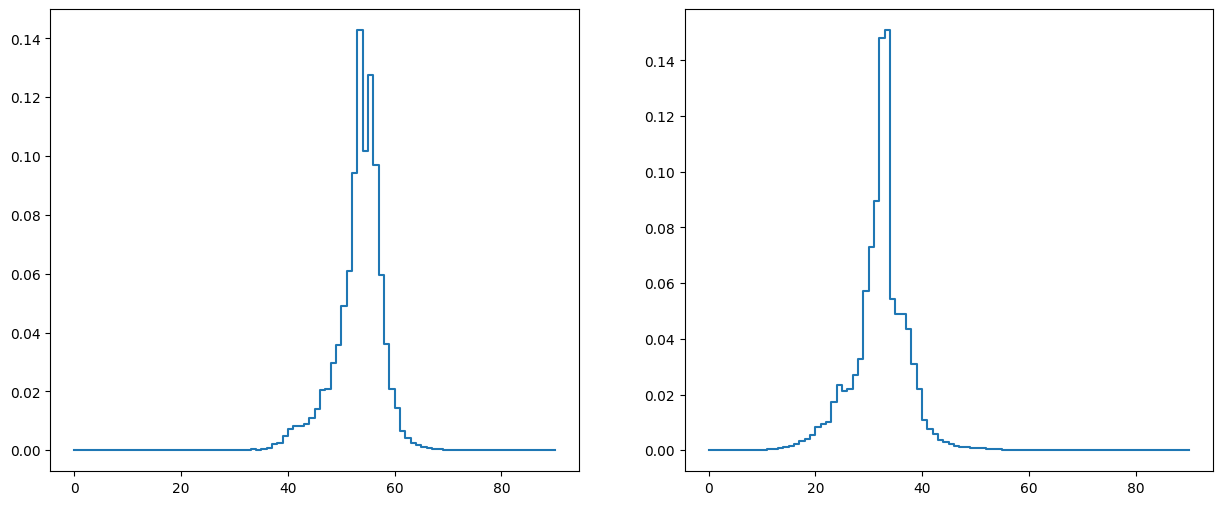

In [33]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr1c_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr1c_preds[pt2].plot_density()

## Next, let's look at results where we don't specify any information about discretization
- ### `binpt_method='auto'`

In [34]:
cr2 = stb.Coarsage(num_trees=5000, learning_rate=.03, binpt_method='auto', loss_fn='log_loss_str',
                   max_depth=8, num_coarse_bins=30)
cr2.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 4.50451733421353
i=10, eval_set_loss = 4.264807286994114
i=20, eval_set_loss = 4.064563223046933
i=30, eval_set_loss = 3.8865556722375536
i=40, eval_set_loss = 3.7784474097139555
i=50, eval_set_loss = 3.700502333691086
i=60, eval_set_loss = 3.6363359921745486
i=70, eval_set_loss = 3.58626970540848
i=80, eval_set_loss = 3.535160744429714
i=90, eval_set_loss = 3.487562510074628
i=100, eval_set_loss = 3.460519628953607
i=110, eval_set_loss = 3.432964768483694
i=120, eval_set_loss = 3.407172285329772
i=130, eval_set_loss = 3.3837167667425505
i=140, eval_set_loss = 3.368889952623756
i=150, eval_set_loss = 3.355763824711962
i=160, eval_set_loss = 3.3548215101916683
i=170, eval_set_loss = 3.3474867581794343
i=180, eval_set_loss = 3.3429741355145253
i=190, eval_set_loss = 3.3406913545871535
i=200, eval_set_loss = 3.3343605145089663
i=210, eval_set_loss = 3.3309940152431476
i=220, eval_set_loss = 3.3357692497630125
i=230, eval_set_loss = 3.3385589293595026
i=240, eval_set_l

In [35]:
cr2_preds = cr2.predict_distributions(X_test)
cr2_preds.log_loss(y_test), cr2_preds.crps_mean(y_test)

(np.float64(3.0265430698109212), np.float64(3.0852948515585488))

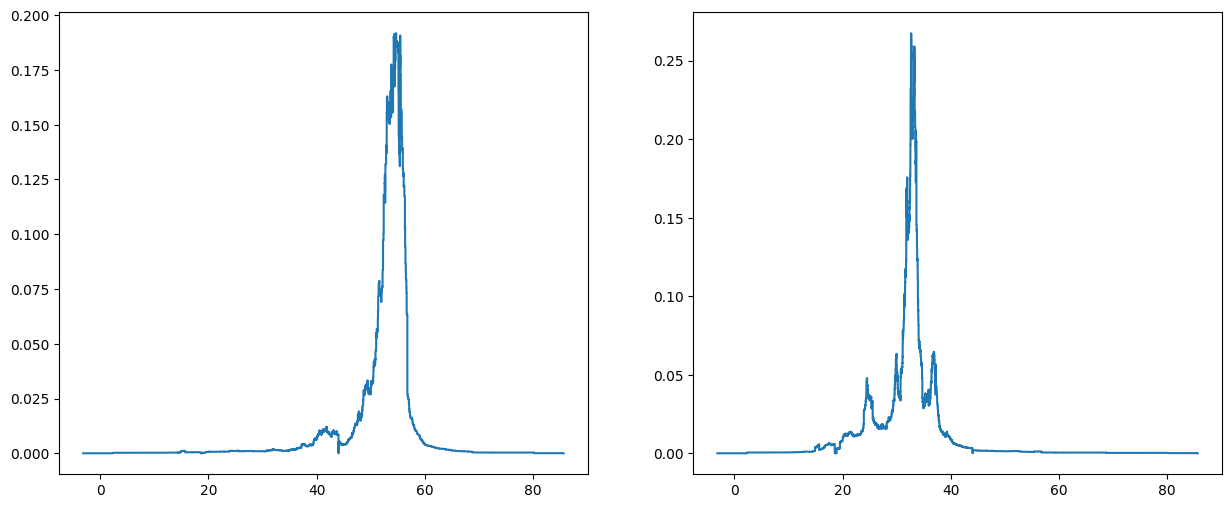

In [36]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr2_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr2_preds[pt2].plot_density()

- ### In `auto` mode, you may see spikes where it finds very local signal about values that are more or less common
- ### E.g. in house prices, may spike up at multiples of 10,000 or 100,0000 (round numbers more likely) and be low at "unlikely" prices like 553,297.
- ### This could be good or bad, depending on your application.
- ### Log_loss definitely improves by finding this signal, but may not be useful in some cases.
- ### This is why the discretization choices are important

In [37]:
cr4 = stb.Coarsage(num_trees=5000, learning_rate=.03, binpt_method='auto',
                   max_depth=8, num_coarse_bins=25, loss_fn='crps_disc')
cr4.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps = 5)

i=0, eval_set_loss = 9.068977438776965
i=10, eval_set_loss = 7.634450392294855
i=20, eval_set_loss = 6.473312679738162
i=30, eval_set_loss = 5.563288416489628
i=40, eval_set_loss = 4.941946067316156
i=50, eval_set_loss = 4.477989977641273
i=60, eval_set_loss = 4.19313863119758
i=70, eval_set_loss = 3.9884475043153187
i=80, eval_set_loss = 3.8343060890641683
i=90, eval_set_loss = 3.719466063690541
i=100, eval_set_loss = 3.616837928039126
i=110, eval_set_loss = 3.5633480737710763
i=120, eval_set_loss = 3.5238792492916042
i=130, eval_set_loss = 3.476701378521605
i=140, eval_set_loss = 3.4150732734383733
i=150, eval_set_loss = 3.3922135240028637
i=160, eval_set_loss = 3.3598268785013454
i=170, eval_set_loss = 3.3257017852838655
i=180, eval_set_loss = 3.2908858470806224
i=190, eval_set_loss = 3.25510637591705
i=200, eval_set_loss = 3.2375927948418486
i=210, eval_set_loss = 3.213646498220712
i=220, eval_set_loss = 3.20123957829204
i=230, eval_set_loss = 3.1843268472040225
i=240, eval_set_los

In [38]:
cr4_preds = cr4.predict_distributions(X_test)
cr4_preds.log_loss(y_test), cr4_preds.crps_mean(y_test)

(np.float64(3.053893298876776), np.float64(2.6495259018129063))

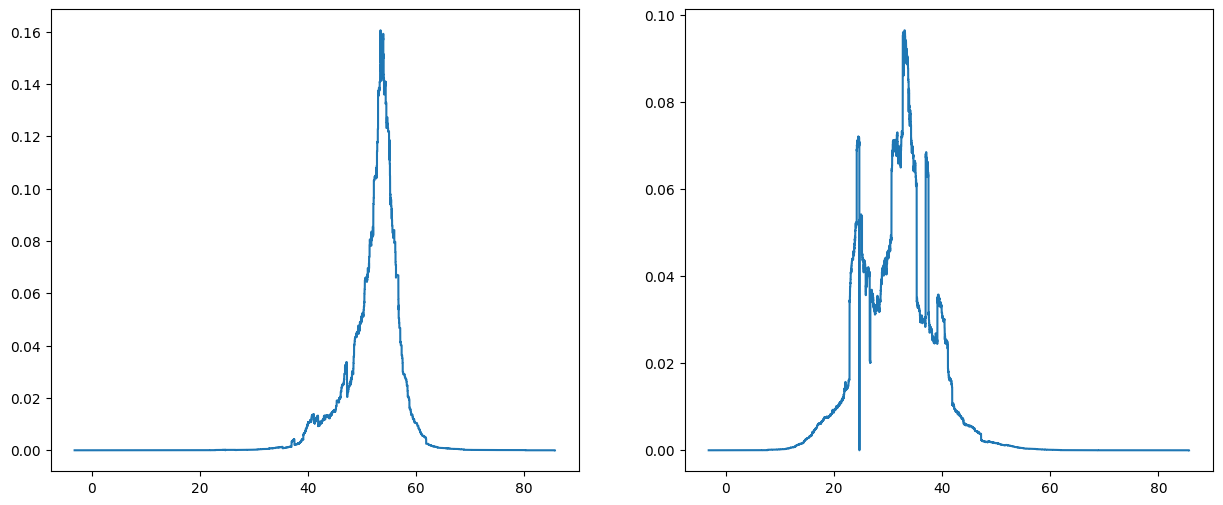

In [39]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
cr4_preds[pt1].plot_density()
plt.subplot(1,2,2)
cr4_preds[pt2].plot_density()

## Integer valued targets
- ### In the previous, we focused on "continuous" target values.
- ### When values are constrained to integers, we can use Coarsage in a manner to reflect the naturally "discrete" nature
- ### View the probability distribution as point masses at the center of the bin, rather than uniformly distributed within each bin

## Tips for integer distributions
- ### Determine your upper and lower range (create bins for "x and higher" or " x and lower" if necessary)
- ### Use either `binpt_method` = `fixed` or `fixed_rss` (do not use `auto`)
- ### Specify your `binpt_vec` so that the midpoints correspond to the integers in question
- ### Ideally, every bin will have width 1
- ### Interpret the density value as the probability of being exactly that integer value

## Baseball Runs Scored
- ### Here we load n a data set of MLB games.
  ### Each row gives some statistics of the hitting team, the opposing pitchers, and the number of runs that were scored.  We will demonstrate how to predict the distribution of the number of runs scored.

In [40]:
# Use if repo is cloned and running locally
# df_runs = pd.read_csv('../ODSC_East_2023/bball_runs_sm.csv')

# Use if running on Google Colab
df_runs = pd.read_csv('https://raw.githubusercontent.com/numeristical/resources/refs/heads/master/ODSC_East_2023/bball_runs_sm.csv')


In [41]:
print(df_runs.shape)

(24284, 13)


In [42]:
df_runs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24284 entries, 0 to 24283
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            24284 non-null  int64  
 1   date_dblhead     24284 non-null  int64  
 2   team_h           24284 non-null  object 
 3   team_v           24284 non-null  object 
 4   home_hitting     24284 non-null  int64  
 5   runs             24284 non-null  int64  
 6   OBP_162          24284 non-null  float64
 7   SLG_162          24284 non-null  float64
 8   Strt_WHIP_35     24284 non-null  float64
 9   Strt_SO_perc_10  24284 non-null  float64
 10  Bpen_WHIP_75     24284 non-null  float64
 11  Bpen_SO_perc_75  24284 non-null  float64
 12  Bpen_WHIP_35     24284 non-null  float64
dtypes: float64(7), int64(4), object(2)
memory usage: 2.4+ MB


In [43]:
df_runs.sample(5, random_state=0)

,index,date_dblhead,team_h,team_v,home_hitting,runs,OBP_162,SLG_162,Strt_WHIP_35,Strt_SO_perc_10,Bpen_WHIP_75,Bpen_SO_perc_75,Bpen_WHIP_35
2894,2894,201605090,BOS,OAK,1,14,0.327880,0.430111,1.171053,0.195219,1.256228,0.204282,1.079019
13085,13085,201506150,ANA,ARI,0,7,0.304823,0.373391,1.246575,0.115942,1.263393,0.230519,1.217712
15829,15829,201607050,WAS,MIL,0,5,0.318220,0.394835,1.387755,0.272727,1.143307,0.272727,1.261589
3662,3662,201607040,MIN,OAK,1,1,0.306786,0.406504,1.450607,0.128205,1.349045,0.230129,1.385224
16642,16642,201609070,NYA,TOR,0,0,0.329603,0.443924,1.547619,0.175000,1.185286,0.276382,1.313559


In [44]:
# Create a column for season
df_runs['season']=df_runs.date_dblhead.apply(lambda x: int(str(x)[:4]))

In [45]:
# Truncate the runs at an upper value of 16 (so 16 represents 16 or more)
df_runs['runs_trunc'] = np.minimum(df_runs['runs'],16)


In [46]:
df_runs.season.value_counts()

season
2017    4860
2015    4858
2019    4858
2016    4854
2018    4854
Name: count, dtype: int64

In [47]:
df_train = df_runs[df_runs.season<=2017]
df_valid = df_runs[df_runs.season==2018]
df_test = df_runs[df_runs.season>=2019]

## Begin Modeling

In [48]:
bpv = np.arange(0,18)-.5
bpv

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5, 11.5, 12.5, 13.5, 14.5, 15.5, 16.5])

This gives us 17 bins, representing 0, 1, 2, ..., 16+ runs scored for that team

In [49]:
feat_set = ['OBP_162',
 'SLG_162',
 'Strt_WHIP_35',
 'Strt_SO_perc_10',
 'Bpen_WHIP_75',
 'Bpen_SO_perc_75',
 'Bpen_WHIP_35']
target = 'runs'

In [50]:
# def try_features_runs(feat_set, max_depth=2):
target = 'runs_trunc'
X_train = df_train.loc[:,feat_set]
X_valid = df_valid.loc[:,feat_set]
X_test = df_test.loc[:,feat_set]

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [51]:
cr_bb1 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  binpt_method = 'fixed', loss_fn='log_loss_str',
               binpt_vec=bpv)
cr_bb1.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 2.4490039762731746
i=10, eval_set_loss = 2.4461476346461826
i=20, eval_set_loss = 2.444170312387797
i=30, eval_set_loss = 2.442561412003207
i=40, eval_set_loss = 2.4413205295364366
i=50, eval_set_loss = 2.440680353700598
i=60, eval_set_loss = 2.4404502068717147
i=70, eval_set_loss = 2.440223817837822
i=80, eval_set_loss = 2.440400832365389
i=90, eval_set_loss = 2.440507078575545
i=100, eval_set_loss = 2.4407266462121475
i=110, eval_set_loss = 2.440598732908706
i=120, eval_set_loss = 2.440846893448357
Stopping early: low pt was 5 steps ago


In [52]:
preds_test_bb1 = cr_bb1.predict_distributions(X_test)

In [53]:
preds_test_bb1.log_loss(y_test), preds_test_bb1.crps_mean(y_test)

(np.float64(2.50026321021628), np.float64(1.8006140212458746))

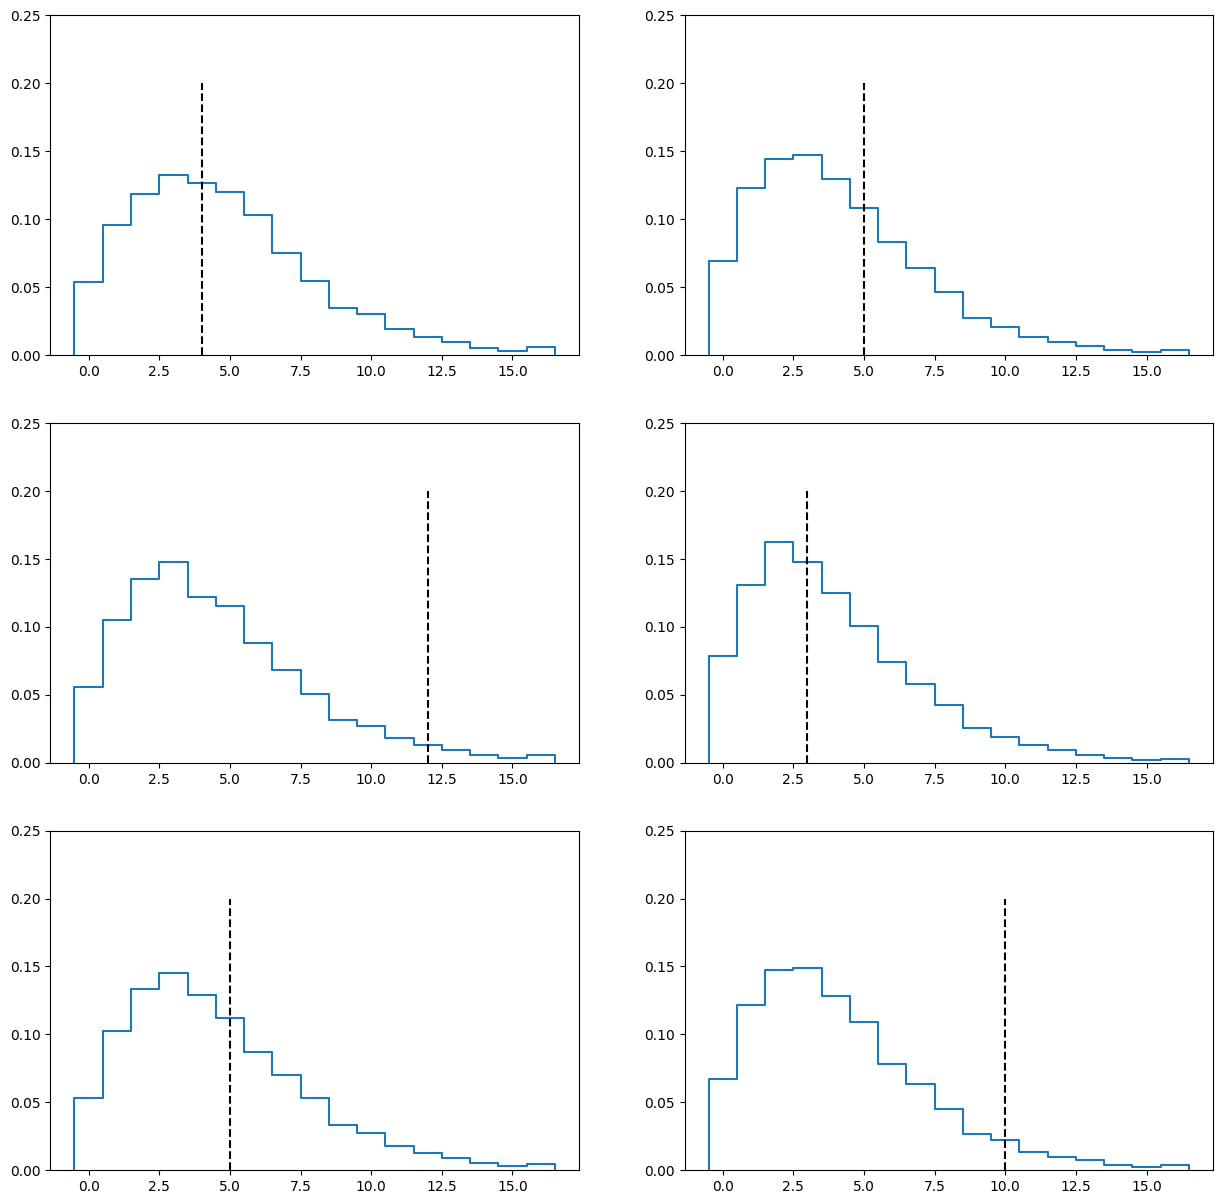

In [54]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test_bb1[i].plot_density()
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

In [55]:
cr_bb2 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  loss_fn='crps_disc', binpt_method='fixed',
               binpt_vec=bpv)
cr_bb2.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 1.7239318776769723
i=10, eval_set_loss = 1.718425068822827
i=20, eval_set_loss = 1.7140570399250452
i=30, eval_set_loss = 1.7109971442280156
i=40, eval_set_loss = 1.7088990879345662
i=50, eval_set_loss = 1.7075155876856312
i=60, eval_set_loss = 1.7063670019174961
i=70, eval_set_loss = 1.7057394172054277
i=80, eval_set_loss = 1.7053065573372206
i=90, eval_set_loss = 1.704906675028646
i=100, eval_set_loss = 1.7045260546220644
i=110, eval_set_loss = 1.704154885549448
i=120, eval_set_loss = 1.704163096569494
i=130, eval_set_loss = 1.7040376669342423
i=140, eval_set_loss = 1.704274911845232
i=150, eval_set_loss = 1.7045109295008627
i=160, eval_set_loss = 1.7045995464754176
i=170, eval_set_loss = 1.704391746847385
i=180, eval_set_loss = 1.7045466295320322
Stopping early: low pt was 5 steps ago


In [56]:
preds_test_bb2 = cr_bb2.predict_distributions(X_test)

In [57]:
preds_test_bb2.log_loss(y_test), preds_test_bb2.crps_mean(y_test)

(np.float64(2.4995300440331465), np.float64(1.7976009810449045))

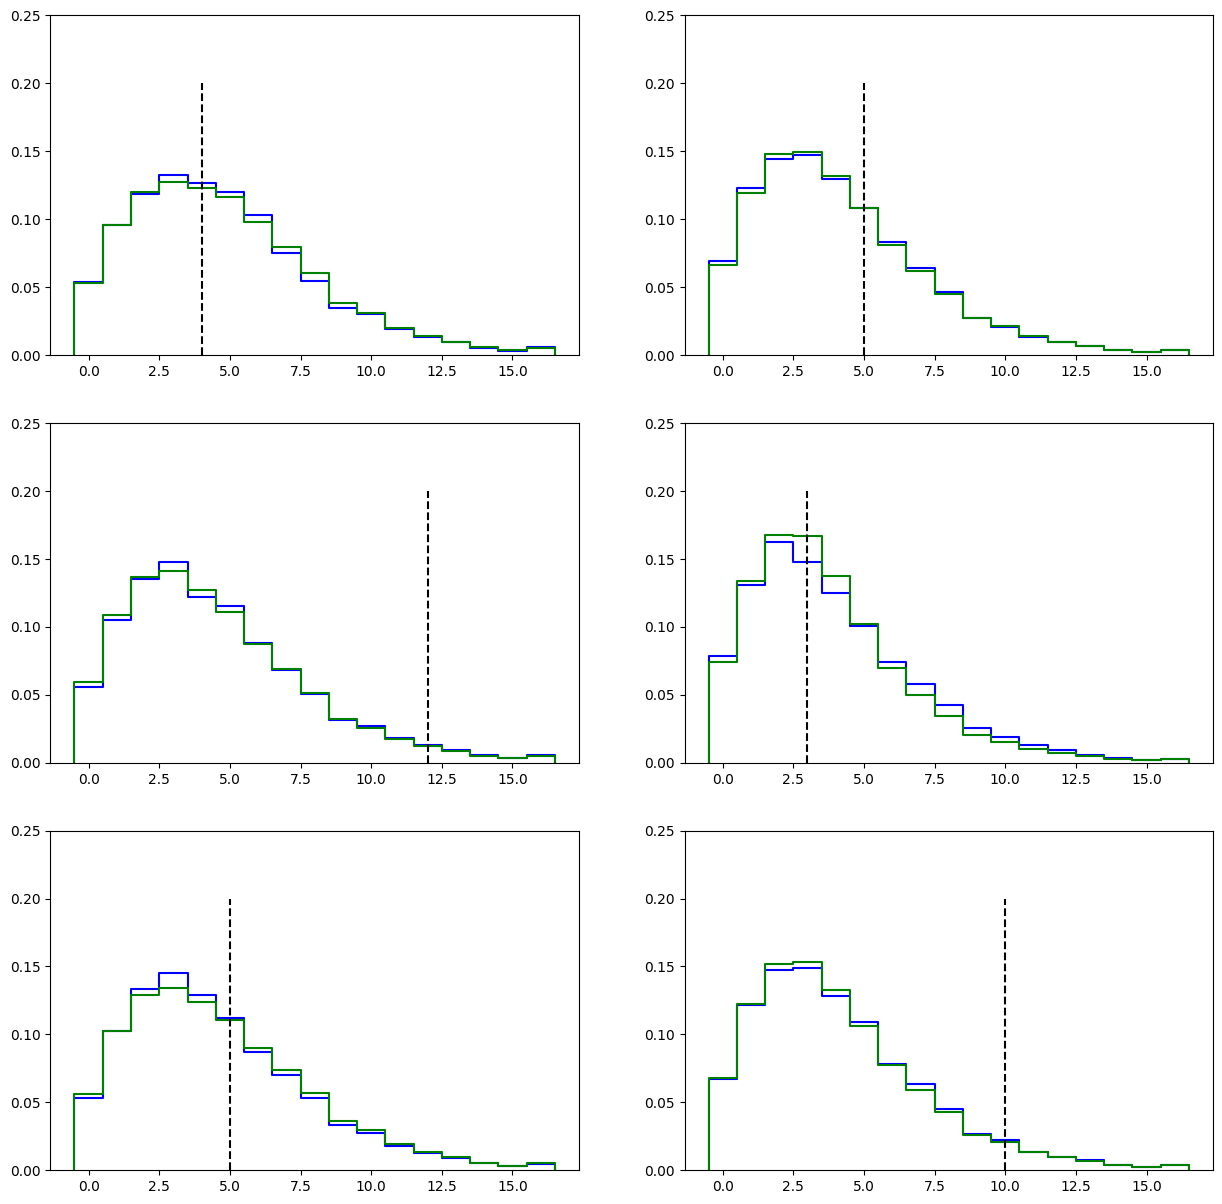

In [58]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test_bb1[i].plot_density(color='blue')
    preds_test_bb2[i].plot_density(color='green')
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

It is *not* recommended to use `binpt_method='auto'` (the default) when you have integer-valued data (for a variety of reasons).  In some situations it may actually give better log-loss values, but it is effectively "cheating" (you can make log-loss as small as you want by making narrower intervals around the integer values)

### One can also try `binpt_method='fixed-rss'`

In [59]:
cr_bb3 = stb.Coarsage(num_trees = 1000, learning_rate=.02, max_depth=4,
                  loss_fn='crps_disc', binpt_method='fixed-rss', num_coarse_bins=10,
               binpt_vec=bpv)
cr_bb3.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stop_past_steps=5, eval_freq=10)

i=0, eval_set_loss = 1.725498367983292
i=10, eval_set_loss = 1.7196434643798473
i=20, eval_set_loss = 1.7154024707592326
i=30, eval_set_loss = 1.7122300657401412
i=40, eval_set_loss = 1.7096515691546863
i=50, eval_set_loss = 1.708033405341128
i=60, eval_set_loss = 1.7068459695033695
i=70, eval_set_loss = 1.7059950721855226
i=80, eval_set_loss = 1.7054919815197387
i=90, eval_set_loss = 1.7051533425543108
i=100, eval_set_loss = 1.7047732854978261
i=110, eval_set_loss = 1.7046010662619153
i=120, eval_set_loss = 1.7046170203231341
i=130, eval_set_loss = 1.7046770671266838
i=140, eval_set_loss = 1.7049898166439907
i=150, eval_set_loss = 1.7052057227269175
i=160, eval_set_loss = 1.705115617388425
Stopping early: low pt was 5 steps ago


In [60]:
preds_test_bb3 = cr_bb3.predict_distributions(X_test)

In [61]:
preds_test_bb3.log_loss(y_test), preds_test_bb3.crps_mean(y_test)

(np.float64(2.506432848811783), np.float64(1.7972913388920733))

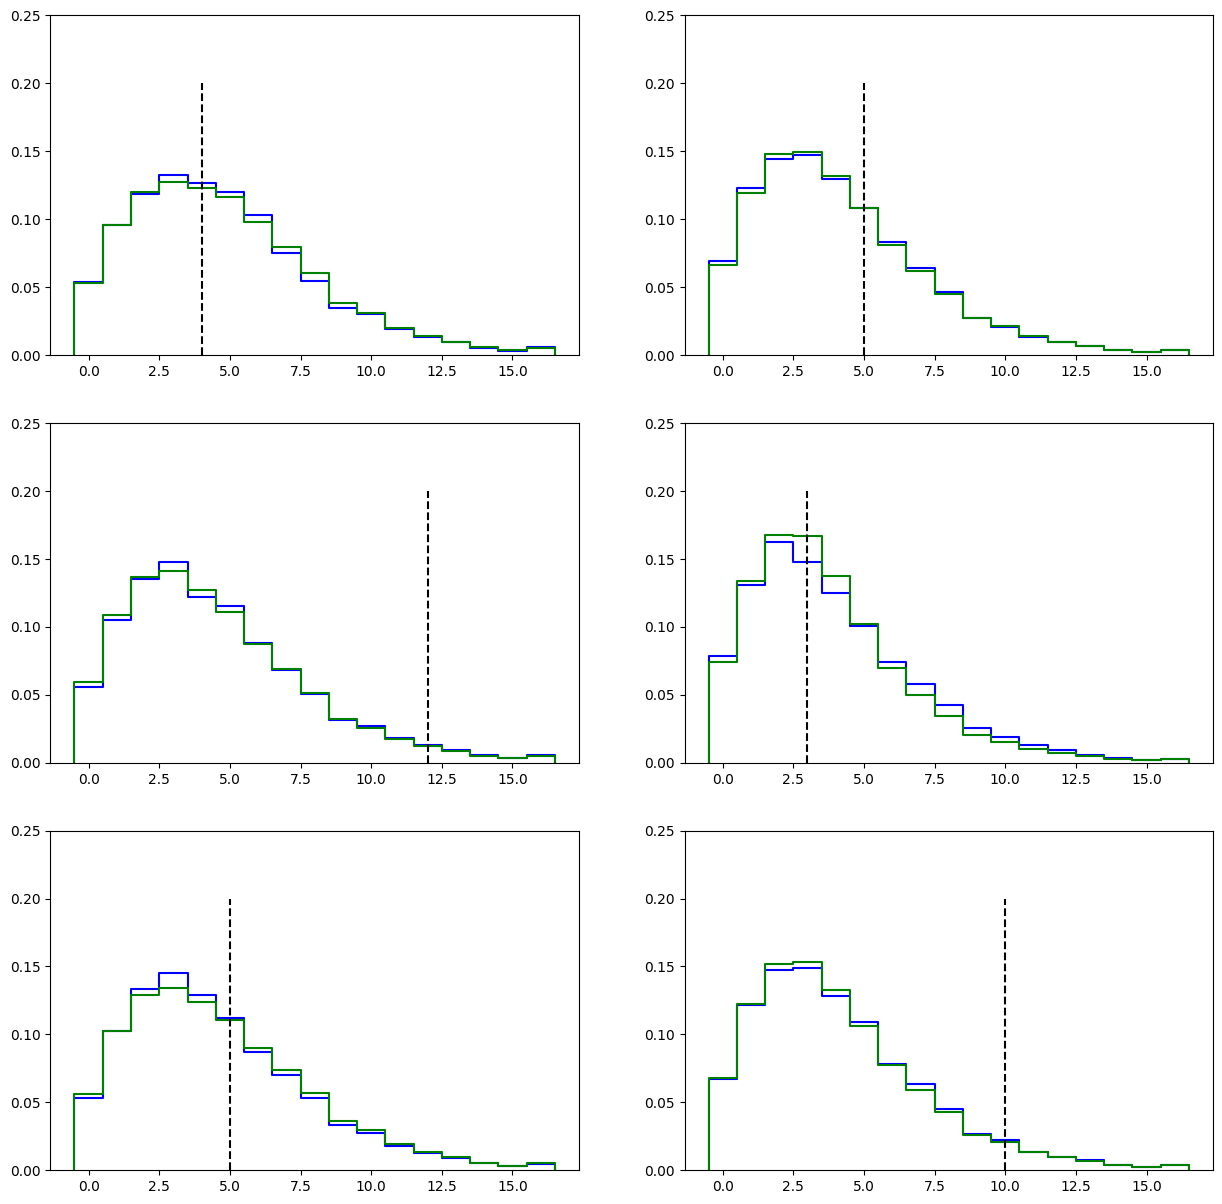

In [62]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    preds_test_bb1[i].plot_density(color='blue')
    preds_test_bb2[i].plot_density(color='green')
    plt.ylim([0,.25])
    plt.vlines(x=y_test[i], ymin=0,ymax=.2, color='k', linestyle='--')

## Final Example: Ames housing data

In [63]:
# Uncomment if running locally
df_house = pd.read_csv('../GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')

# Uncomment if using Google Colab
# df_house = pd.read_csv('https://raw.githubusercontent.com/numeristical/resources/refs/heads/master/GBIP/data/Ames_Housing_Data.tsv', delimiter='\t')


df_house = df_house.loc[df_house['Gr Liv Area']<=4000,:]
df_house['Garage Area'] = df_house['Garage Area'].fillna(0)
df_house.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2925 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2925 non-null   int64  
 1   PID              2925 non-null   int64  
 2   MS SubClass      2925 non-null   int64  
 3   MS Zoning        2925 non-null   object 
 4   Lot Frontage     2435 non-null   float64
 5   Lot Area         2925 non-null   int64  
 6   Street           2925 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2925 non-null   object 
 9   Land Contour     2925 non-null   object 
 10  Utilities        2925 non-null   object 
 11  Lot Config       2925 non-null   object 
 12  Land Slope       2925 non-null   object 
 13  Neighborhood     2925 non-null   object 
 14  Condition 1      2925 non-null   object 
 15  Condition 2      2925 non-null   object 
 16  Bldg Type        2925 non-null   object 
 17  House Style      29

In [64]:
#df_house.columns = [x.replace(' ','_') for x in df_house.columns]

In [65]:
df_house.sample(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
1314,1315,902306120,70,RM,60.0,6000,Pave,Grvl,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,129400
1686,1687,528102100,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
1728,1729,528218020,60,RL,65.0,10237,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,176000
1715,1716,528174010,120,RL,61.0,7577,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,194700
443,444,528142090,20,RL,107.0,11362,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2009,WD,Normal,280000


In [66]:
feat = ['Lot Area','Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Gr Liv Area', 
        'Full Bath', 'Half Bath', 'Bedroom AbvGr',
         'Garage Area', 'Fireplaces']

In [67]:
X = df_house.loc[:,feat]  # everything except Sale Price
y = df_house.SalePrice.to_numpy()

In [68]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 400, random_state=0)

- ### In this case, we will set up bin points to be spaced 2000 apart from 0 to 500,000.
- ### Then, the algorithm will randomly create 20 bins using a selection of these endpoints

In [69]:
cr_h1 = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, num_coarse_bins=20, 
                   binpt_method='fixed-rss', binpt_vec = np.linspace(0,500000,251))
cr_h1.fit(X_train, y_train, eval_set=(X_test, y_test), early_stop_past_steps = 5)

i=0, eval_set_loss = 12.596415340784807
i=10, eval_set_loss = 12.2205856480801
i=20, eval_set_loss = 11.979382473562264
i=30, eval_set_loss = 11.772477004832409
i=40, eval_set_loss = 11.637630577694235
i=50, eval_set_loss = 11.561879413652465
i=60, eval_set_loss = 11.51290316025646
i=70, eval_set_loss = 11.476716670953508
i=80, eval_set_loss = 11.44778867501374
i=90, eval_set_loss = 11.430758758302115
i=100, eval_set_loss = 11.419542225390682
i=110, eval_set_loss = 11.40474841437779
i=120, eval_set_loss = 11.391233495852651
i=130, eval_set_loss = 11.382085180551009
i=140, eval_set_loss = 11.376247726695146
i=150, eval_set_loss = 11.370290503208416
i=160, eval_set_loss = 11.366935963377587
i=170, eval_set_loss = 11.368732717379466
i=180, eval_set_loss = 11.371776276615833
i=190, eval_set_loss = 11.371446082697688
i=200, eval_set_loss = 11.368262308833565
i=210, eval_set_loss = 11.37276335615295
Stopping early: low pt was 5 steps ago


In [70]:
cr_h1_preds = cr_h1.predict_distributions(X_test)
cr_h1_preds.log_loss(y_test), cr_h1_preds.log_loss(y_test)

(np.float64(11.366935963377587), np.float64(11.366935963377587))

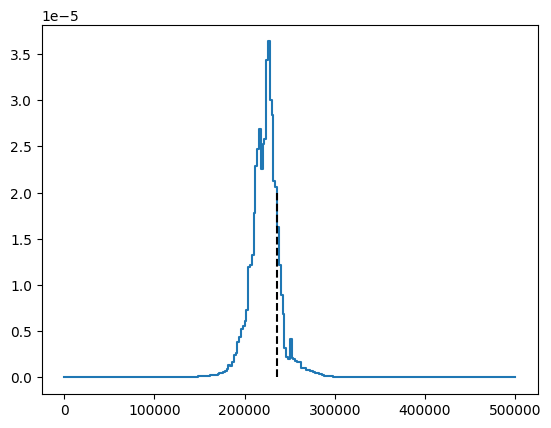

In [71]:
i=0
cr_h1_preds[i].plot_density()
plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

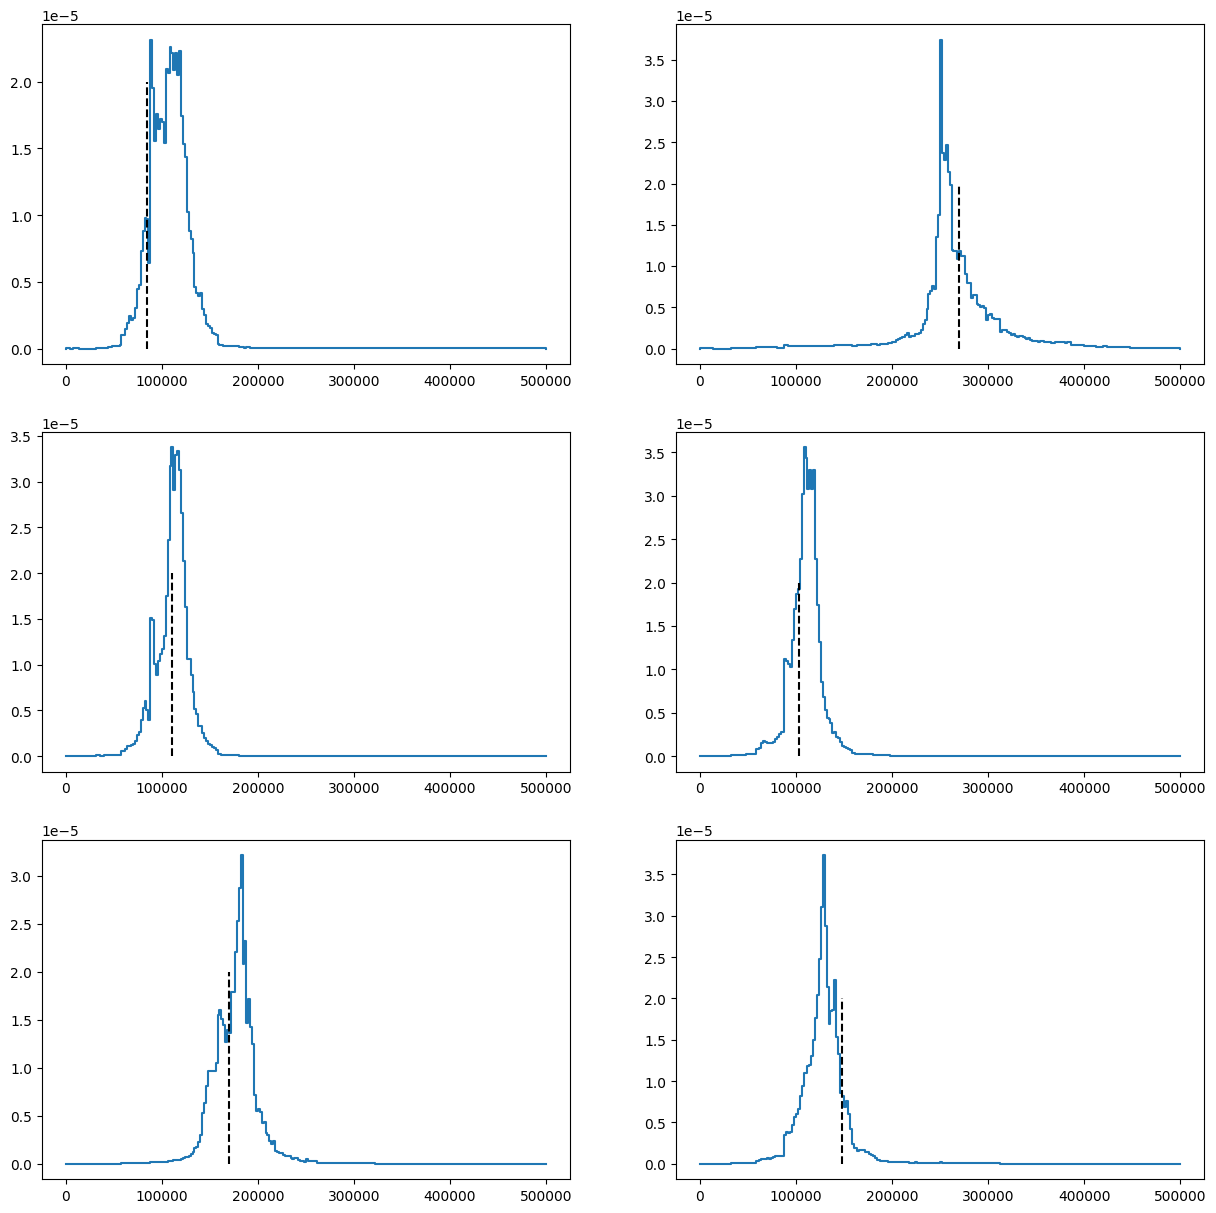

In [72]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    cr_h1_preds[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

In [73]:
cr_h2 = stb.Coarsage(num_trees=2000, learning_rate=.03, max_depth=8, num_coarse_bins=20, 
                   binpt_method='fixed-rss', binpt_vec = np.linspace(0,500000,251), loss_fn='crps_disc')
cr_h2.fit(X_train, y_train, eval_set=(X_test, y_test), early_stop_past_steps = 5)

i=0, eval_set_loss = 39206.490207340474
i=10, eval_set_loss = 32508.343638968458
i=20, eval_set_loss = 27370.14833115582
i=30, eval_set_loss = 23567.737476734117
i=40, eval_set_loss = 20607.101300212635
i=50, eval_set_loss = 18467.741839651488
i=60, eval_set_loss = 16922.24669865339
i=70, eval_set_loss = 15834.373223090553
i=80, eval_set_loss = 14997.604563650084
i=90, eval_set_loss = 14337.712487558983
i=100, eval_set_loss = 13842.935344515561
i=110, eval_set_loss = 13443.672166293964
i=120, eval_set_loss = 13072.642890514895
i=130, eval_set_loss = 12821.720621790406
i=140, eval_set_loss = 12596.975174756311
i=150, eval_set_loss = 12402.924851958416
i=160, eval_set_loss = 12171.932573441369
i=170, eval_set_loss = 12016.813690639034
i=180, eval_set_loss = 11895.6487903245
i=190, eval_set_loss = 11769.199987807018
i=200, eval_set_loss = 11672.570091008027
i=210, eval_set_loss = 11603.350202819456
i=220, eval_set_loss = 11518.733868402873
i=230, eval_set_loss = 11433.579404159243
i=240, 

In [74]:
cr_h2_preds = cr_h2.predict_distributions(X_test)
cr_h2_preds.log_loss(y_test), cr_h2_preds.crps_mean(y_test)

(np.float64(11.342148553909096), np.float64(11009.507587135015))

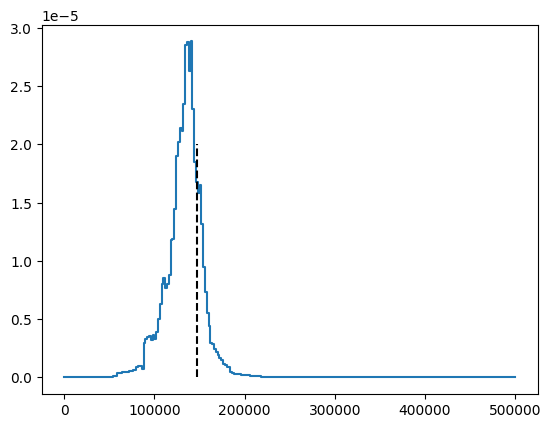

In [75]:
cr_h2_preds[i].plot_density()
plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')

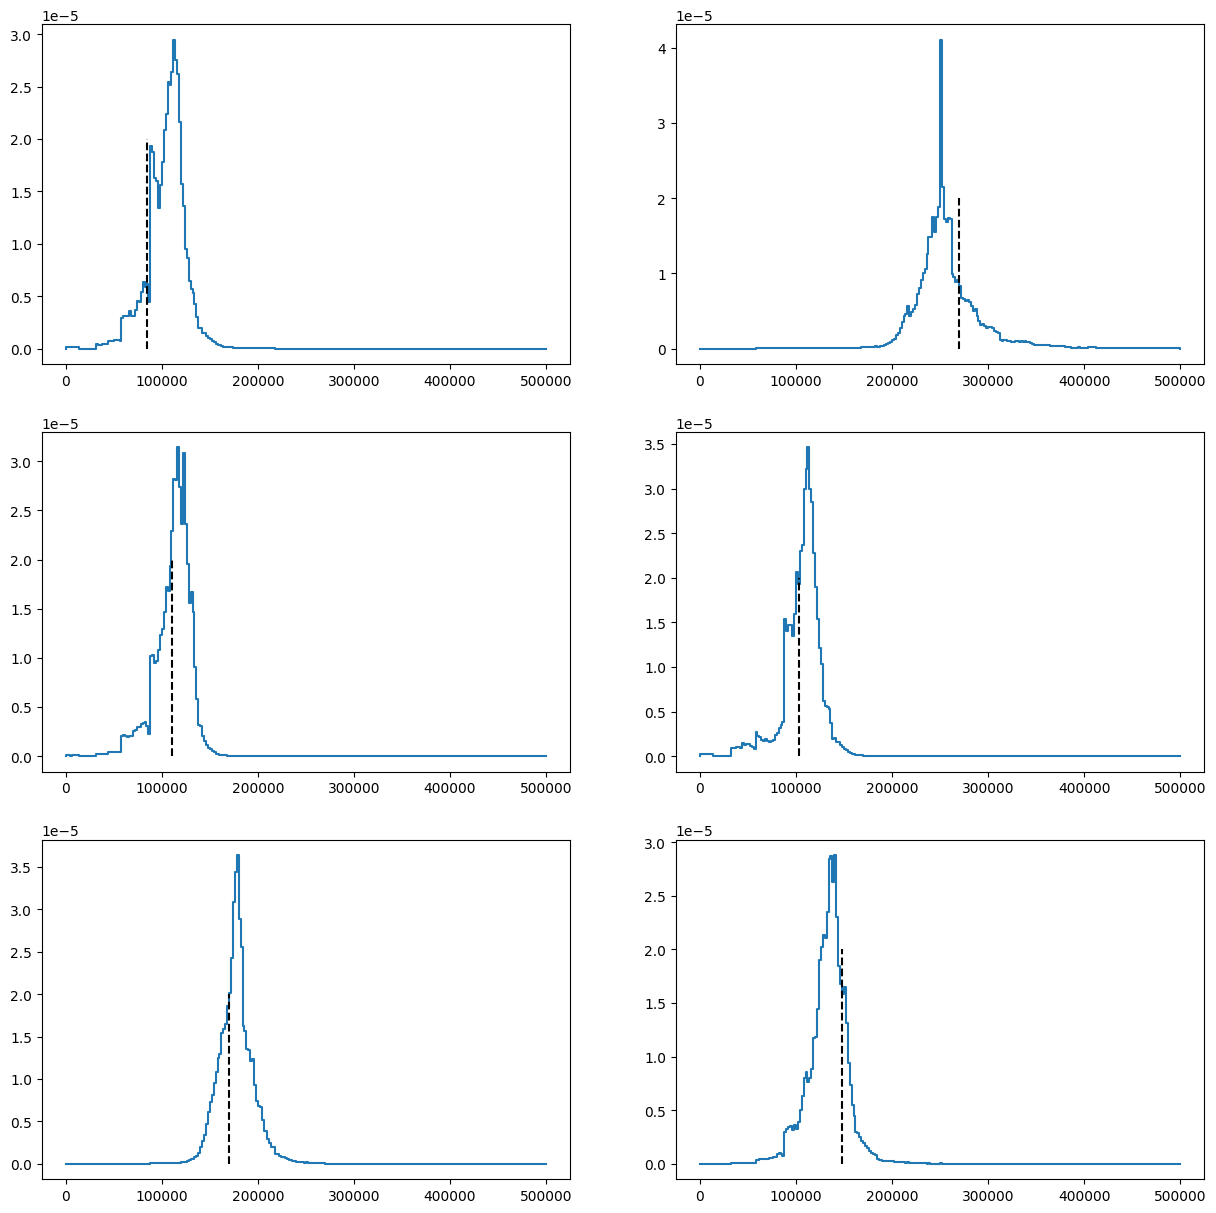

In [76]:
plt.figure(figsize=(15,15))
for i in range(1,7):
    plt.subplot(3,2,i)
    cr_h2_preds[i].plot_density()
    plt.vlines(x=y_test[i], ymin=0,ymax=.00002, color='k', linestyle='--')